In [1]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn 40, 912

#### SET DING0 SETTINGS

In [3]:
# TODO set in config file
ding0_default=False

engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()
create_lvgd_geo_method='convex_hull' # off, convex_hull

In [4]:
%%time

# STEP 1
nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts,
                            ding0_default=ding0_default, need_parameterization=True,
                            create_lvgd_geo_method=create_lvgd_geo_method)

Finding connected graph, iteration 1 of max. 4.
Simplified graph: 94 to 22 nodes, 170 to 26 edges


bicycle_parking is not matched in config and will be categorized as leftover
bicycle_parking is not matched in config and will be categorized as leftover


Simplified graph: 716 to 479 nodes, 1484 to 1010 edges
at least one node trespasses dist to substation.                                cluster again with n_clusters+=1
after increment; n_cluster 5
all clusters are in range
=====> MV Grid Districts imported


Wall time: 9.13 s


In [5]:
# STEP 2
# nd.import_generators(session, debug=False)

In [6]:
%%time

# STEP 3
nd.mv_parametrize_grid(debug=False)

Wall time: 17.5 ms


In [7]:
# STEP 4: Validate MV Grid Districts
msg = nd.validate_grid_districts()

In [8]:
%%time

# STEP 5: Build LV grids
nd.build_lv_grids()

LV grid building for la lv_load_area_4488
LVGD building for lv_grid_district_4488000000
LVGD building for lv_grid_district_4488000001
LVGD building for lv_grid_district_4488000002
LVGD building for lv_grid_district_4488000003
LVGD building for lv_grid_district_4488000004


Wall time: 7.61 s


In [9]:
# STEP 6: Build MV grids
nd.mv_routing(debug=False)

Geo distance is zero, check objects' positions. Distance is set to 1m
Geo distance is zero, check objects' positions. Distance is set to 1m
Geo distance is zero, check objects' positions. Distance is set to 1m
Geo distance is zero, check objects' positions. Distance is set to 1m


In [10]:
# STEP 7: Connect MV and LV generators
nd.connect_generators(debug=False)

C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initial

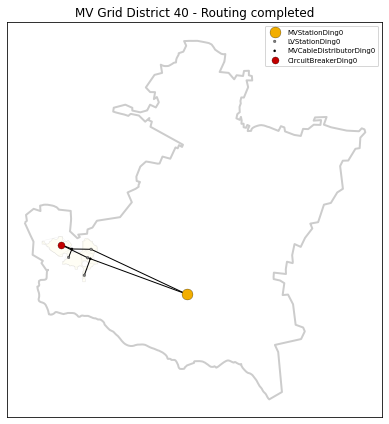

In [10]:
# no aggregated la
grid = nd._mv_grid_districts[0].mv_grid
plot_mv_topology(grid, subtitle='Routing completed', filename=None)

C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initial

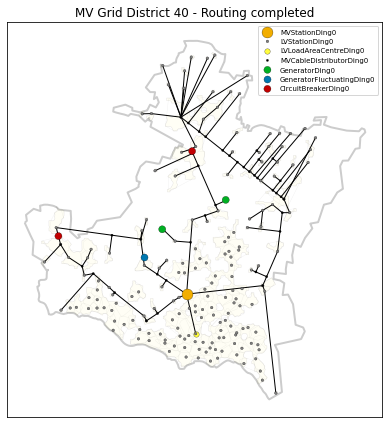

In [11]:
# with aggregated la
grid = nd._mv_grid_districts[0].mv_grid
plot_mv_topology(grid, subtitle='Routing completed', filename=None)

In [11]:
# STEP 8: Relocate switch disconnectors in MV grid
nd.set_circuit_breakers(debug=False)

In [12]:
# STEP 9: Open all switch disconnectors in MV grid
nd.control_circuit_breakers(mode='open')

In [13]:
# check if there are isolated nodes or lv grids may be not connected in one graph
import networkx as nx
stop = False
for la in nd._mv_grid_districts[0]._lv_load_areas:
    for lvgd in la._lv_grid_districts:
        if len(lvgd.lv_grid.graph_isolated_nodes()):
            print('\n' + str(lvgd) + ' has isl\n', lvgd.lv_grid.graph_isolated_nodes())
        g = list(nx.connected_components(lvgd.lv_grid._graph))
        if len(g) > 1:
            print(str(lvgd) + 'has multiple connected components')
            # stop = True
            # break
    if stop:
        break

In [14]:
# check for connected components in graph and isolated nodes
g = list(nx.connected_components(nd._mv_grid_districts[0].mv_grid._graph))
nd._mv_grid_districts[0].mv_grid.graph_isolated_nodes(), len(g)

([circuit_breaker_1], 2)

In [15]:
%%time

# STEP 10: Do power flow analysis of MV grid
nd.run_powerflow(session, method='onthefly', only_calc_mv=False, export_pypsa=True, debug=False)

GET NODES
GET EDGES
GET TRAFOS
GOING TO nodes_to_dict_of_dataframes
GOING TO edges_to_dict_of_dataframes
GOING TO merge_two_dicts
STARTING TO EXPORT LV
STARTING TO EXPORT LVLA lv_load_area_4488
STARTING TO EXPORT LVGD lv_grid_district_4488000000. Going to fill_component_dataframes.
GET NODES
GET EDGES
GET TRAFOS
GOING TO nodes_to_dict_of_dataframes
GOING TO edges_to_dict_of_dataframes
GOING TO merge_two_dicts
STARTING TO EXPORT LVGD lv_grid_district_4488000001. Going to fill_component_dataframes.
GET NODES
GET EDGES
GET TRAFOS
GOING TO nodes_to_dict_of_dataframes
GOING TO edges_to_dict_of_dataframes
GOING TO merge_two_dicts
STARTING TO EXPORT LVGD lv_grid_district_4488000002. Going to fill_component_dataframes.
GET NODES
GET EDGES
GET TRAFOS
GOING TO nodes_to_dict_of_dataframes
GOING TO edges_to_dict_of_dataframes
GOING TO merge_two_dicts
STARTING TO EXPORT LVGD lv_grid_district_4488000003. Going to fill_component_dataframes.
GET NODES
GET EDGES
GET TRAFOS
GOING TO nodes_to_dict_of_dat

Wall time: 2min 2s


In [16]:
from ding0.tools.pypsa_io import initialize_component_dataframes, fill_mvgd_component_dataframes, data_integrity, create_powerflow_problem, transform_timeseries4pypsa, import_series_from_dataframe, _check_integrity_of_pypsa
from pandas import date_range
from datetime import datetime


In [17]:
%%time

for grid_district in nd.mv_grid_districts():
    print('\n ITERATION STARTING')
    buses_df, generators_df, lines_df, loads_df, transformer_df = initialize_component_dataframes()
    components, _, components_data = fill_mvgd_component_dataframes(grid_district.mv_grid.grid_district, buses_df, generators_df,
                                                                            lines_df, loads_df, transformer_df,
                                                                            only_export_mv=False,
                                                                            return_time_varying_data=True)
    print('\n ITERATION DONE')



 ITERATION STARTING


INFO:ding0:MV grid 40 exported to pypsa format.
INFO:ding0:LV grid 4488000000 exported to pypsa format.
INFO:ding0:LV grid 4488000001 exported to pypsa format.
INFO:ding0:LV grid 4488000002 exported to pypsa format.
INFO:ding0:LV grid 4488000003 exported to pypsa format.
INFO:ding0:LV grid 4488000004 exported to pypsa format.



 ITERATION DONE
Wall time: 1min 48s


In [18]:
# create pypsa network
# choose temp_id
timesteps = 2
start_time = datetime(1970, 1, 1, 00, 00, 0)
resolution = 'H'

# define investigated time range
timerange = date_range(freq=resolution,
                       periods=timesteps,
                       start=start_time)
network, snapshots = create_powerflow_problem(timerange, components)


In [19]:
# import pq-sets
for key in ['Load', 'Generator']:
    for attr in ['p_set', 'q_set']:
        # catch MV grid districts without generators
        if not components_data[key].empty:
            series = transform_timeseries4pypsa(components_data[key][
                                                    attr].to_frame(),
                                                timerange,
                                                column=attr)
            import_series_from_dataframe(network,
                                         series,
                                         key,
                                         attr)

series = transform_timeseries4pypsa(components_data['Bus']
                                    ['v_mag_pu_set'].to_frame(),
                                    timerange,
                                    column='v_mag_pu_set')

import_series_from_dataframe(network,
                             series,
                             'Bus',
                             'v_mag_pu_set')

C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pypsa\io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))


In [20]:
_check_integrity_of_pypsa(network)

In [21]:
network.lpf()
network.pf(use_seed=True)


INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 01:00:00'], dtype='datetime64[ns]', freq='H')
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 01:00:00'], dtype='datetime64[ns]', freq='H')
INFO:pypsa.pf:Newton-Raphson solved in 100 iterations with error of 100285341588422053968838914738806666183764532608975409187634111524907020245495981556690006346195259547087156847955010387968.000000 in 6.515193 seconds
INFO:pypsa.pf:Newton-Raphson solved in 0 iterations with error of 0.000000 in 0.024832 seconds


{'n_iter':                        0
 1970-01-01 00:00:00  100
 1970-01-01 01:00:00    0,
 'error':                                  0
 1970-01-01 00:00:00  1.002853e+122
 1970-01-01 01:00:00   2.505374e-11,
 'converged':                          0
 1970-01-01 00:00:00  False
 1970-01-01 01:00:00   True}

In [22]:
print(f"Line: there is na is {components['Line'][['length', 'bus0', 'bus1', 's_nom', 'type_info']].isnull().values.any()}")
print(f"Load: there is na is {components['Load'].isnull().values.any()}")


Line: there is na is False
Load: there is na is False


In [23]:
# there are buses for loads called *_loa which are connected to em ding0cabledistributor via 1 meter
# but loads are connected directly to this ding0cabledistributor and not to *_load
# in step 5 in ding0.grid.lv_grid.build_grid_on_osm_ways number of added loads == len(loa)
loa = network.buses.loc[network.buses.x.isna()].index.tolist()  # we know these buses have no coordinates

dellines = network.lines.loc[network.lines.bus1.isin(loa)].index.tolist()
len(dellines), len(loa)

(935, 935)

In [24]:
network.mremove("Bus", loa)
network.mremove("Line", dellines)

In [25]:
network.lpf()
network.pf(use_seed=True)

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 01:00:00'], dtype='datetime64[ns]', freq='H')
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 01:00:00'], dtype='datetime64[ns]', freq='H')
INFO:pypsa.pf:Newton-Raphson solved in 100 iterations with error of 26835657037325986453676725183976792418721663022054523273216.000000 in 5.910404 seconds
INFO:pypsa.pf:Newton-Raphson solved in 0 iterations with error of 0.000000 in 0.019818 seconds


{'n_iter':                        0
 1970-01-01 00:00:00  100
 1970-01-01 01:00:00    0,
 'error':                                 0
 1970-01-01 00:00:00  2.683566e+58
 1970-01-01 01:00:00  2.505374e-11,
 'converged':                          0
 1970-01-01 00:00:00  False
 1970-01-01 01:00:00   True}

In [27]:
e1 = 100285341588422053968838914738806666183764532608975409187634111524907020245495981556690006346195259547087156847955010387968.000000 
e2 = 26835657037325986453676725183976792418721663022054523273216.000000  

'by removing loa and dellines, err reduced by', e1 - e2

('by removing load and dellines, err reduced by', 1.0028534158842205e+122)

In [31]:
network.export_to_csv_folder(export_path)

INFO:pypsa.io:Exported network kluftern has transformers, lines, buses, loads, generators


In [32]:
loa

['Bus_mvgd_40_lvgd_4488000000_loa_1',
 'Bus_mvgd_40_lvgd_4488000000_loa_2',
 'Bus_mvgd_40_lvgd_4488000000_loa_3',
 'Bus_mvgd_40_lvgd_4488000000_loa_4',
 'Bus_mvgd_40_lvgd_4488000000_loa_5',
 'Bus_mvgd_40_lvgd_4488000000_loa_6',
 'Bus_mvgd_40_lvgd_4488000000_loa_7',
 'Bus_mvgd_40_lvgd_4488000000_loa_8',
 'Bus_mvgd_40_lvgd_4488000000_loa_9',
 'Bus_mvgd_40_lvgd_4488000000_loa_10',
 'Bus_mvgd_40_lvgd_4488000000_loa_11',
 'Bus_mvgd_40_lvgd_4488000000_loa_12',
 'Bus_mvgd_40_lvgd_4488000000_loa_13',
 'Bus_mvgd_40_lvgd_4488000000_loa_14',
 'Bus_mvgd_40_lvgd_4488000000_loa_15',
 'Bus_mvgd_40_lvgd_4488000000_loa_16',
 'Bus_mvgd_40_lvgd_4488000000_loa_17',
 'Bus_mvgd_40_lvgd_4488000000_loa_18',
 'Bus_mvgd_40_lvgd_4488000000_loa_19',
 'Bus_mvgd_40_lvgd_4488000000_loa_20',
 'Bus_mvgd_40_lvgd_4488000000_loa_21',
 'Bus_mvgd_40_lvgd_4488000000_loa_22',
 'Bus_mvgd_40_lvgd_4488000000_loa_23',
 'Bus_mvgd_40_lvgd_4488000000_loa_24',
 'Bus_mvgd_40_lvgd_4488000000_loa_25',
 'Bus_mvgd_40_lvgd_4488000000_loa_